In [24]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import Counter

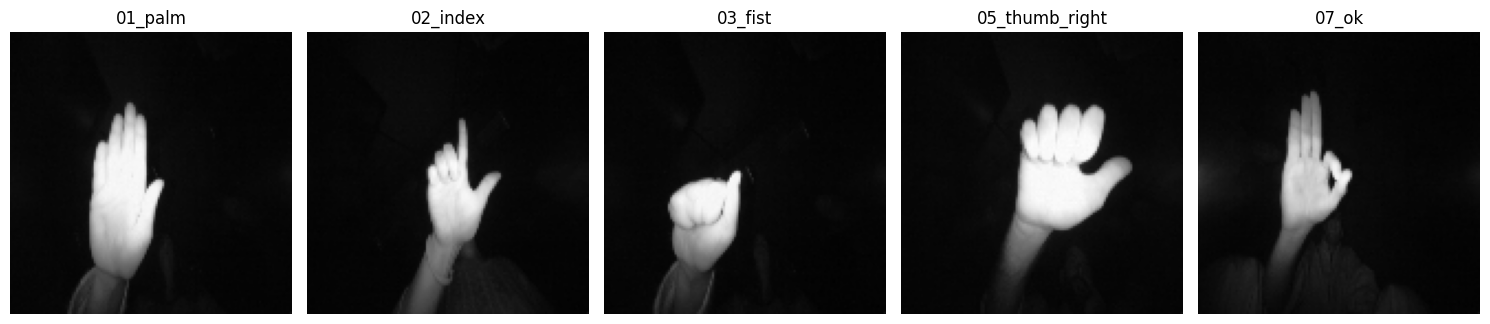

In [25]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

# Dataset Path
dataset_path = r"Hand-Gesture\leapGestRecog\dataset"

# Gesture Labels
gestures = ["01_palm", "02_index", "03_fist", "05_thumb_right", "07_ok"]
gesture_map = {gesture: i for i, gesture in enumerate(gestures)}

# Display Sample Images
fig, axes = plt.subplots(1, len(gestures), figsize=(15, 5))

for i, gesture in enumerate(gestures):
    gesture_folder = os.path.join(dataset_path, gesture)
    
    if not os.path.exists(gesture_folder):
        print(f"❌ Folder not found: {gesture_folder}")
        continue

    image_files = os.listdir(gesture_folder)
    if not image_files:
        print(f"⚠️ No images found in {gesture_folder}")
        continue

    random_image = random.choice(image_files)
    img_path = os.path.join(gesture_folder, random_image)

    # Read and Resize Image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))  # Resize to prevent crashes

    # Display Image
    axes[i].imshow(img)
    axes[i].set_title(gesture)
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [26]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical

# Parameters
img_size = (64, 64)  # Resize images
X, y = [], []

# Load Images & Labels
for gesture in gestures:
    gesture_folder = os.path.join(dataset_path, gesture)
    label = gesture_map[gesture]
    
    for img_file in os.listdir(gesture_folder):
        img_path = os.path.join(gesture_folder, img_file)
        
        # Load and preprocess image
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize
        
        X.append(img)
        y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(gestures))

print(f"✅ Data Loaded: {X.shape[0]} images, Shape: {X.shape}")


✅ Data Loaded: 10000 images, Shape: (10000, 64, 64, 3)


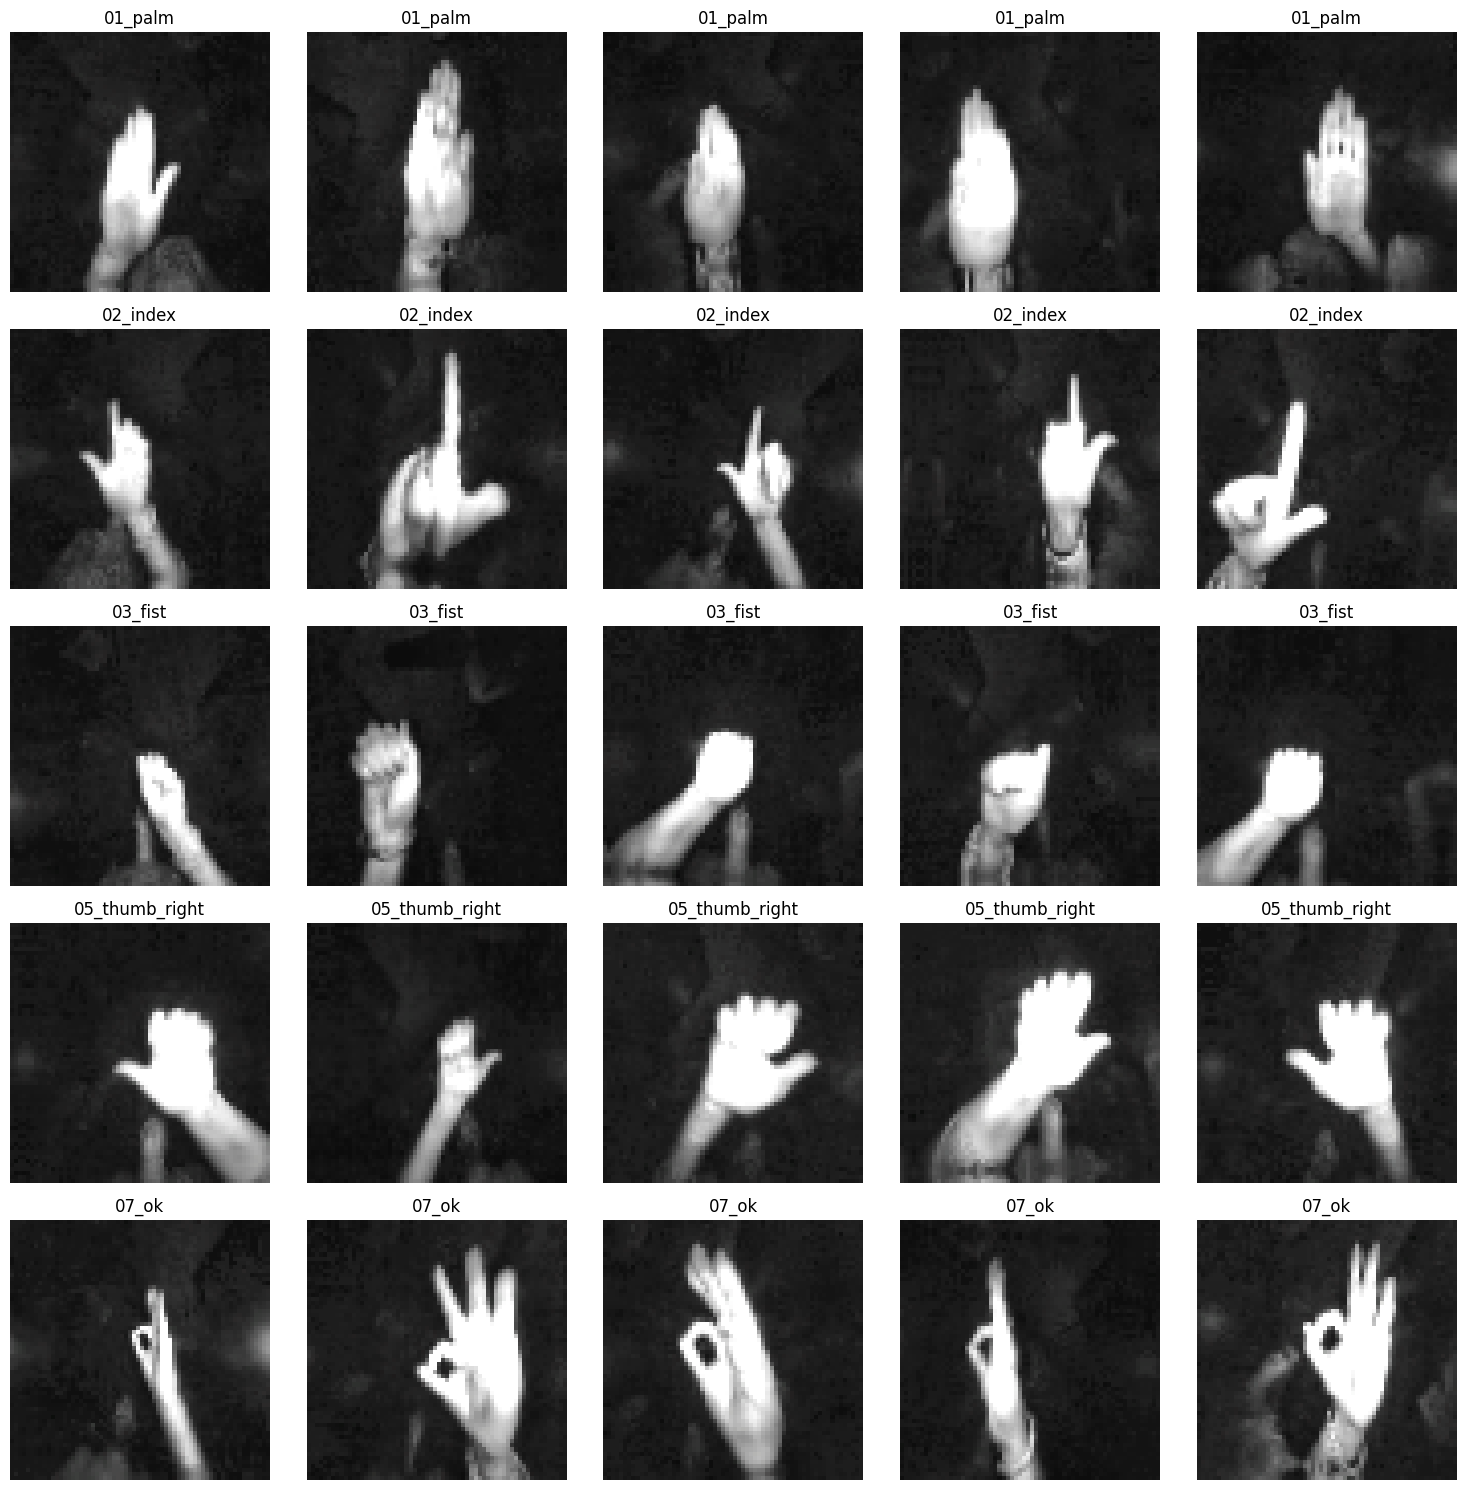

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.05,  
    zoom_range=0.05,  
    horizontal_flip=True,
    brightness_range=[1.0, 1.2],  # Reduce brightness boost
    fill_mode='reflect'
)
def enhance_contrast(img):
    img = (img * 255).astype(np.uint8)  
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8, 8))  # Lower clipLimit for less over-sharpening
    img = clahe.apply(img)  
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Dictionary to store augmented images
augmented_images = {gesture: [] for gesture in gestures}

# Augment entire dataset
for i in range(len(X)):
    img = X[i].astype(np.float32)  # Convert to float32
    img = enhance_contrast(img)  # Apply contrast enhancement
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    aug_img = datagen.flow(img, batch_size=1)[0][0]  # Apply augmentation

    # 🔹 FIX: Convert one-hot encoded label back to integer index
    gesture_label = np.argmax(y[i])  # Get the integer class label
    augmented_images[gestures[gesture_label]].append(aug_img)  # Store by gesture class

# Display 5 random augmented images per gesture class
fig, axes = plt.subplots(len(gestures), 5, figsize=(15, len(gestures) * 3))

for row, (gesture, images) in enumerate(augmented_images.items()):
    random_indices = np.random.choice(len(images), 5, replace=False)
    for col, idx in enumerate(random_indices):
        axes[row, col].imshow(images[idx].astype(np.uint8))
        axes[row, col].axis("off")
        axes[row, col].set_title(gesture)

plt.tight_layout()
plt.show()

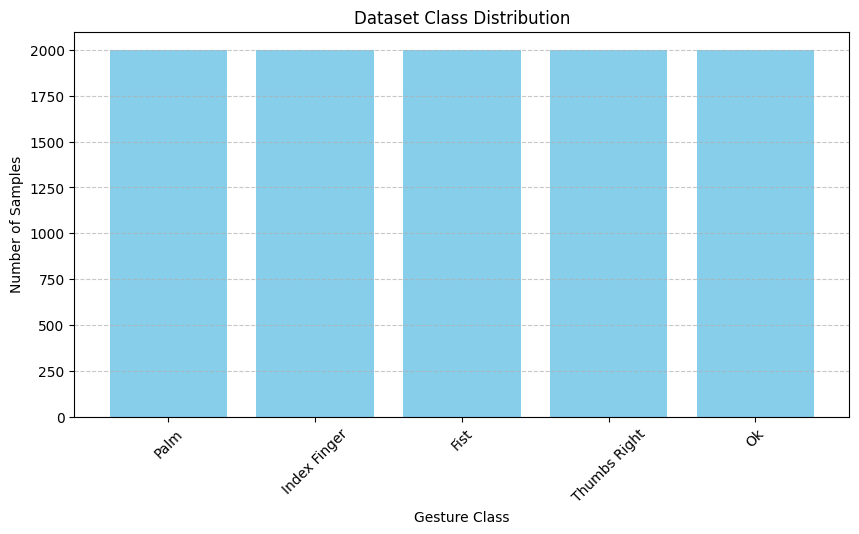

In [47]:
# Define custom class names
custom_class_labels = ["Palm", "Index Finger", "Fist", "Thumbs Right", "Ok"]  # Modify as needed

# Use this instead of gestures in the plot
plt.figure(figsize=(10, 5))
plt.bar(custom_class_labels, class_counts, color='skyblue')

plt.xlabel("Gesture Class")
plt.ylabel("Number of Samples")
plt.title("Dataset Class Distribution")
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [51]:
from sklearn.model_selection import train_test_split

# Convert dataset to NumPy arrays if not already
X = np.array(X, dtype=np.float32)  
y = np.array(y, dtype=np.float32)

# Split into training (80%), temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training Samples: {len(X_train)}")
print(f"Validation Samples: {len(X_val)}")
print(f"Testing Samples: {len(X_test)}")


Training Samples: 8000
Validation Samples: 1000
Testing Samples: 1000


In [54]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Fix input size: Use a supported size like (96, 96, 3)
base_model = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights="imagenet")

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Ensures the correct shape
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)  # Reduce overfitting
output_layer = Dense(len(gestures), activation='softmax')(x)  # ✅ Properly connect this layer

# Compile the full model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ✅ Stop training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

# ✅ Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    "best_hand_gesture_model.h5",  
    monitor='val_accuracy',  
    save_best_only=True,  
    mode='max',  
    verbose=1
)

# ✅ Reduce learning rate if validation loss plateaus for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

# 📌 Combine all callbacks
callbacks = [early_stopping, checkpoint, reduce_lr]


In [60]:
print("X_train shape:", X_train.shape)
print("Total elements in X_train:", X_train.size)


X_train shape: (8000, 64, 64, 3)
Total elements in X_train: 98304000


In [66]:
# Normalize input images
X_train_resized = np.array([cv2.resize(img, (96, 96)) for img in X_train]).astype('float32') / 255.0
X_val_resized = np.array([cv2.resize(img, (96, 96)) for img in X_val]).astype('float32') / 255.0
X_test_resized = np.array([cv2.resize(img, (96, 96)) for img in X_test]).astype('float32') / 255.0

# Since y_train is already one-hot encoded, use it directly
y_train_cat = y_train
y_val_cat = y_val
y_test_cat = y_test

# ✅ Check final shape before training
print("X_train_resized shape:", X_train_resized.shape)  # Should be (8000, 96, 96, 3)
print("y_train_cat shape:", y_train_cat.shape)  # Should be (8000, num_classes)
print("X_val_resized shape:", X_val_resized.shape)  
print("y_val_cat shape:", y_val_cat.shape) 

# ✅ Start training
history = model.fit(
    X_train_resized, y_train_cat,  
    validation_data=(X_val_resized, y_val_cat),  
    epochs=30,  
    batch_size=32,  
    callbacks=callbacks,  
    verbose=1  
)

# ✅ Save final trained model
model.save("final_hand_gesture_model.h5")


X_train_resized shape: (8000, 96, 96, 3)
y_train_cat shape: (8000, 5)
X_val_resized shape: (1000, 96, 96, 3)
y_val_cat shape: (1000, 5)
Epoch 1/30


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.